Lap Times Schema:
root
 |-- raceId: string (nullable = true)
 |-- driverId: string (nullable = true)
 |-- lap: string (nullable = true)
 |-- position: string (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)

Sample data:
+------+--------+---+--------+--------+------------+
|raceId|driverId|lap|position|    time|milliseconds|
+------+--------+---+--------+--------+------------+
|   841|      20|  1|       1|1:38.109|       98109|
|   841|      20|  2|       1|1:33.006|       93006|
|   841|      20|  3|       1|1:32.713|       92713|
|   841|      20|  4|       1|1:32.803|       92803|
|   841|      20|  5|       1|1:32.342|       92342|
+------+--------+---+--------+--------+------------+
only showing top 5 rows

Column names in lap_times DataFrame: ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']
Column names in drivers DataFrame: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', '

/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/04/29 05:36:13 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Random Forest model trained and logged with run_id: 0a0af64c85a1484db3d5e963c810f0eb
Training Gradient Boosting model...
Gradient Boosting model trained successfully!
Gradient Boosting Metrics:
  MSE: 4687008589.98
  RMSE: 68461.73
  MAE: 13602.23
  R²: 0.0251


2025/04/29 05:38:53 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.
/databricks/python/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


Gradient Boosting model trained and logged with run_id: c9cf66421dc54cbc8a24d3f0ecce9e9f
Creating predictions dataset...
Predictions saved to artifacts/model_predictions.csv

Sample predictions:
        race_id  driver_id  actual_time  rf_predicted_time  gb_predicted_time
48849       879         30        90194       84993.904097       84547.371266
213438      984          1       121990       96537.938040       98130.614082
296821     1064        852        80565       99011.607126       95612.273809
427192       87         30        74292       82023.650746       81886.105767
174708      354         20       118887       94445.677771       92562.272681

Model Performance Comparison:
Random Forest RMSE: 69199.90, R²: 0.0040
Gradient Boosting RMSE: 68461.73, R²: 0.0251
Improvement: 1.07% reduction in RMSE

MLflow Run IDs for later reference:
Random Forest: 0a0af64c85a1484db3d5e963c810f0eb
Gradient Boosting: c9cf66421dc54cbc8a24d3f0ecce9e9f


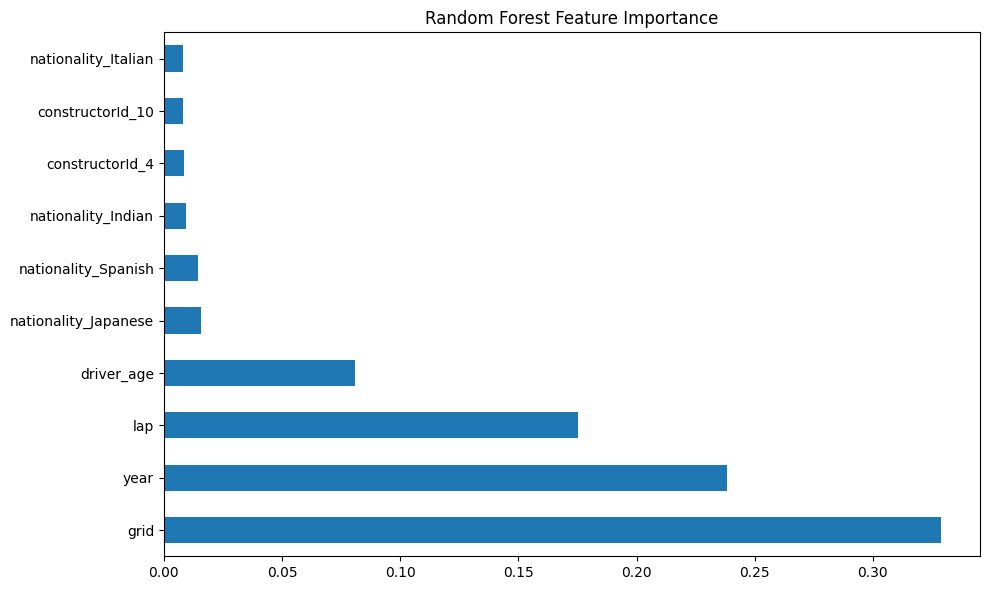

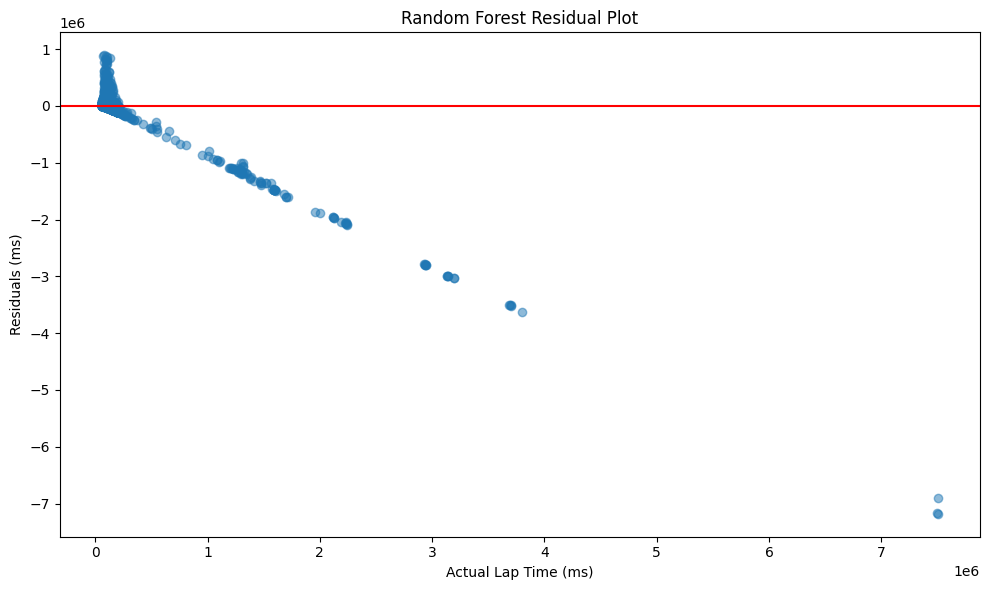

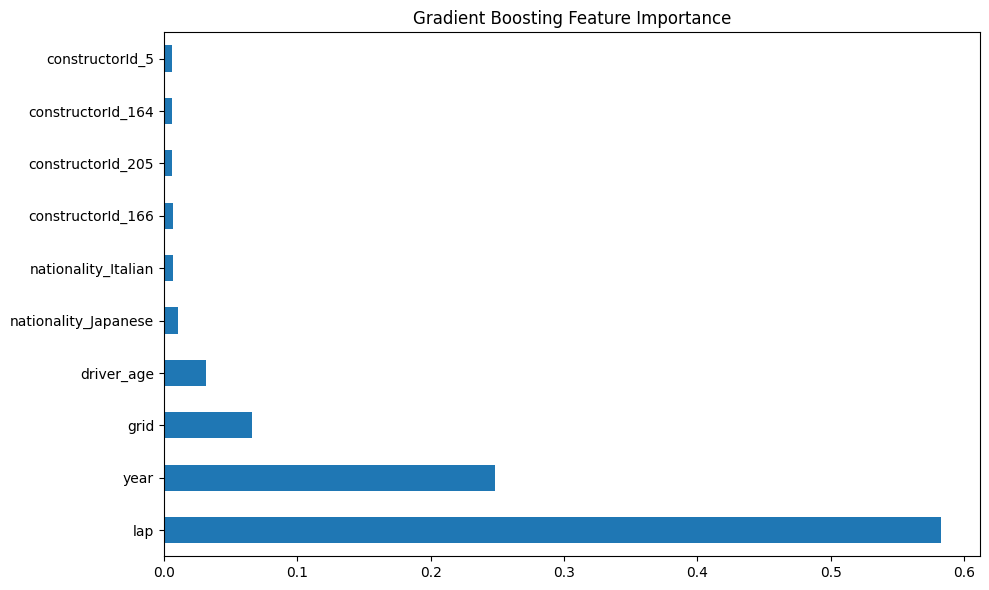

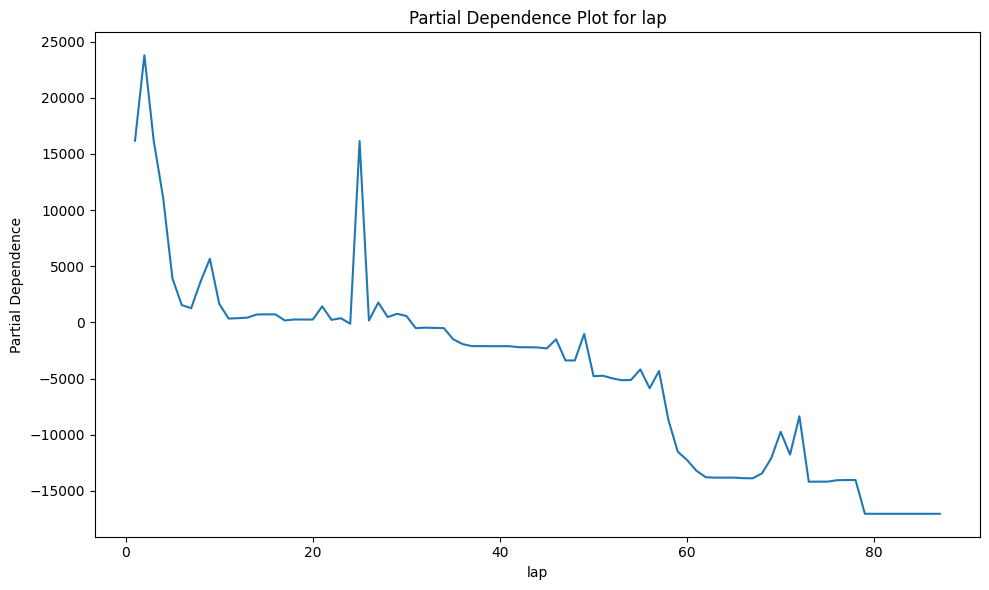

In [0]:
# Import necessary libraries
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from pyspark.sql.functions import col
import os
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

# Set MLflow tracking URI - Replace with your Databricks workspace URL
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/lq2242@columbia.edu/F1-Predictions")

# Create directory for artifacts if it doesn't exist
os.makedirs("artifacts", exist_ok=True)

# Load data from S3
df_laptimes = spark.read.csv('s3://columbia-gr5069-main/raw/lap_times.csv', header=True)
df_drivers = spark.read.csv('s3://columbia-gr5069-main/raw/drivers.csv', header=True)
df_pitstops = spark.read.csv('s3://columbia-gr5069-main/raw/pit_stops.csv', header=True)
df_results = spark.read.csv('s3://columbia-gr5069-main/raw/results.csv', header=True)
df_races = spark.read.csv('s3://columbia-gr5069-main/raw/races.csv', header=True)

# Display the schema to debug column names
print("Lap Times Schema:")
df_laptimes.printSchema()
print("Sample data:")
df_laptimes.show(5)

# Data preprocessing function with more robust error handling
def preprocess_data(lap_times_df, drivers_df, results_df, races_df):
    # Convert PySpark DataFrames to Pandas
    lap_times = lap_times_df.toPandas()
    drivers = drivers_df.toPandas()
    results = results_df.toPandas()
    races = races_df.toPandas()
    
    # Print column names to debug
    print("Column names in lap_times DataFrame:", lap_times.columns.tolist())
    print("Column names in drivers DataFrame:", drivers.columns.tolist())
    print("Column names in results DataFrame:", results.columns.tolist())
    print("Column names in races DataFrame:", races.columns.tolist())
    
    # Check if milliseconds column exists in lap_times
    target_column = 'milliseconds'
    if target_column not in lap_times.columns:
        # Try alternative column names if the expected one doesn't exist
        if 'millis' in lap_times.columns:
            target_column = 'millis'
        elif 'time_ms' in lap_times.columns:
            target_column = 'time_ms'
        elif 'time' in lap_times.columns:
            target_column = 'time'
        else:
            # If we can't find the target column, print first few rows to debug
            print("First 5 rows of lap_times:")
            print(lap_times.head())
            raise KeyError(f"Target column 'milliseconds' or alternatives not found in lap_times DataFrame")
    
    # Convert string columns to appropriate numeric types
    lap_times[target_column] = pd.to_numeric(lap_times[target_column], errors='coerce')
    
    # Convert ID columns to integers in all DataFrames
    for df, df_name in [(lap_times, 'lap_times'), (drivers, 'drivers'), (results, 'results'), (races, 'races')]:
        for col_name in df.columns:
            if col_name in ['driverId', 'raceId', 'constructorId']:
                print(f"Converting {col_name} in {df_name} to integer")
                df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
                df[col_name] = df[col_name].fillna(-1).astype(int)
    
    # Perform merges with inner join to ensure we only keep matching rows
    print("DataFrame shapes before merging:")
    print("lap_times:", lap_times.shape)
    print("drivers:", drivers.shape)
    print("results:", results.shape)
    print("races:", races.shape)
    
    # Merge with drivers
    df = pd.merge(lap_times, drivers, on='driverId', how='inner')
    print("After merging with drivers:", df.shape)
    
    # Merge with results
    df = pd.merge(df, results, on=['raceId', 'driverId'], how='inner', suffixes=('', '_results'))
    print("After merging with results:", df.shape)
    
    # Merge with races
    df = pd.merge(df, races, on='raceId', how='inner', suffixes=('', '_races'))
    print("After merging with races:", df.shape)
    
    # Feature engineering - handle potential missing columns
    try:
        df['driver_age'] = pd.to_datetime(df['date']).dt.year - pd.to_datetime(df['dob']).dt.year
    except KeyError as e:
        print(f"Warning: Could not calculate driver_age, missing column: {e}")
        # Create a default age if needed
        df['driver_age'] = 25
    
    # Extract additional features with error handling
    try:
        df['year'] = pd.to_datetime(df['date']).dt.year
    except KeyError:
        # Try alternative or use a default
        if 'year' in df.columns:
            print("Using existing 'year' column")
        else:
            print("Creating default 'year' column")
            df['year'] = 2020  # Default value
    
    try:
        df['lap'] = df['lap'].astype(int)
    except KeyError:
        print("Warning: 'lap' column not found, creating default")
        df['lap'] = 1  # Default value
    
    # One-hot encode categorical features with error handling
    categorical_cols = []
    if 'nationality' in df.columns:
        categorical_cols.append('nationality')
    if 'constructorId' in df.columns:
        categorical_cols.append('constructorId')
    
    if categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Ensure target column exists
    if target_column not in df.columns:
        # Check for alternative target columns after merging
        if 'time' in df.columns:
            target_column = 'time'
        elif 'time_ms' in df.columns:
            target_column = 'time_ms'
        else:
            raise KeyError(f"Target column '{target_column}' or alternatives not found in merged DataFrame")
    
    # Create feature list with safety checks
    base_features = []
    for feature in ['lap', 'driver_age', 'grid', 'year']:
        if feature in df.columns:
            base_features.append(feature)
    
    # Add one-hot encoded columns
    categorical_features = [col for col in df.columns if 
                           ('nationality_' in col or 'constructorId_' in col)]
    
    feature_cols = base_features + categorical_features
    
    # Ensure at least some features exist
    if not feature_cols:
        raise ValueError("No valid features found in processed DataFrame")
    
    print(f"Selected {len(feature_cols)} features including:")
    print(feature_cols[:5], "..." if len(feature_cols) > 5 else "")
    
    X = df[feature_cols]
    y = df[target_column]
    
    return X, y, df

# Preprocess the data with comprehensive error handling
try:
    X, y, full_data = preprocess_data(df_laptimes, df_drivers, df_results, df_races)
    print(f"Successfully preprocessed data: X shape = {X.shape}, y shape = {y.shape}")
except Exception as e:
    print(f"Error during preprocessing: {e}")
    import traceback
    traceback.print_exc()
    raise

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest Regressor
with mlflow.start_run(run_name="RandomForestModel") as run:
    # Set hyperparameters
    n_estimators = 100
    max_depth = 10
    min_samples_split = 5
    
    # Log hyperparameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("min_samples_split", min_samples_split)
    mlflow.log_param("model_type", "RandomForest")
    
    # Train model
    print("Training Random Forest model...")
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    rf_model.fit(X_train, y_train)
    print("Random Forest model trained successfully!")
    
    # Make predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Calculate metrics
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    
    # Print metrics
    print(f"Random Forest Metrics:")
    print(f"  MSE: {mse_rf:.2f}")
    print(f"  RMSE: {rmse_rf:.2f}")
    print(f"  MAE: {mae_rf:.2f}")
    print(f"  R²: {r2_rf:.4f}")
    
    # Log metrics
    mlflow.log_metric("mse", mse_rf)
    mlflow.log_metric("rmse", rmse_rf)
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("r2", r2_rf)
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    # Create feature importance plot as artifact
    plt.figure(figsize=(10, 6))
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    
    # Save plot
    artifact_path = "artifacts/rf_feature_importance.png"
    plt.savefig(artifact_path)
    
    # Log artifact
    mlflow.log_artifact(artifact_path)
    
    # Create residual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf - y_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Actual Lap Time (ms)')
    plt.ylabel('Residuals (ms)')
    plt.title('Random Forest Residual Plot')
    plt.tight_layout()
    
    # Save plot
    artifact_path = "artifacts/rf_residual_plot.png"
    plt.savefig(artifact_path)
    
    # Log artifact
    mlflow.log_artifact(artifact_path)
    
    # Store run_id for later use
    rf_run_id = run.info.run_id
    
    print(f"Random Forest model trained and logged with run_id: {rf_run_id}")

# Model 2: Gradient Boosting Regressor
with mlflow.start_run(run_name="GradientBoostingModel") as run:
    # Set hyperparameters
    n_estimators = 100
    learning_rate = 0.1
    max_depth = 5
    
    # Log hyperparameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("model_type", "GradientBoosting")
    
    # Train model
    print("Training Gradient Boosting model...")
    gb_model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    print("Gradient Boosting model trained successfully!")
    
    # Make predictions
    y_pred_gb = gb_model.predict(X_test)
    
    # Calculate metrics
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    rmse_gb = np.sqrt(mse_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)
    
    # Print metrics
    print(f"Gradient Boosting Metrics:")
    print(f"  MSE: {mse_gb:.2f}")
    print(f"  RMSE: {rmse_gb:.2f}")
    print(f"  MAE: {mae_gb:.2f}")
    print(f"  R²: {r2_gb:.4f}")
    
    # Log metrics
    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("rmse", rmse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    
    # Log model
    mlflow.sklearn.log_model(gb_model, "gradient_boosting_model")
    
    # Create feature importance plot as artifact
    plt.figure(figsize=(10, 6))
    feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title('Gradient Boosting Feature Importance')
    plt.tight_layout()
    
    # Save plot
    artifact_path = "artifacts/gb_feature_importance.png"
    plt.savefig(artifact_path)
    
    # Log artifact
    mlflow.log_artifact(artifact_path)
    
    # Create partial dependence plot
    try:
        plt.figure(figsize=(10, 6))
        # Use the most important feature based on the above importance plot
        most_important_feature = feature_importances.idxmax()
        feature_idx = list(X.columns).index(most_important_feature)
        
        pdp = partial_dependence(gb_model, X_train, [feature_idx], kind='average')
        plt.plot(pdp['values'][0], pdp['average'][0])
        plt.xlabel(most_important_feature)
        plt.ylabel('Partial Dependence')
        plt.title(f'Partial Dependence Plot for {most_important_feature}')
        plt.tight_layout()
        
        # Save plot
        artifact_path = "artifacts/gb_partial_dependence.png"
        plt.savefig(artifact_path)
        
        # Log artifact
        mlflow.log_artifact(artifact_path)
    except Exception as e:
        print(f"Warning: Could not create partial dependence plot: {e}")
    
    # Store run_id for later use
    gb_run_id = run.info.run_id
    
    print(f"Gradient Boosting model trained and logged with run_id: {gb_run_id}")

# Save predictions to be used later
try:
    print("Creating predictions dataset...")
    # Check if DataFrame has index information
    if hasattr(X_test, 'index') and hasattr(full_data, 'iloc'):
        # Handle case where X_test index might not match full_data
        common_indices = set(X_test.index).intersection(set(full_data.index))
        if len(common_indices) < len(X_test):
            print(f"Warning: Only {len(common_indices)} of {len(X_test)} test indices found in full data")
        
        predictions_df = pd.DataFrame({
            'race_id': full_data.loc[X_test.index, 'raceId'] if 'raceId' in full_data.columns else -1,
            'driver_id': full_data.loc[X_test.index, 'driverId'] if 'driverId' in full_data.columns else -1,
            'actual_time': y_test,
            'rf_predicted_time': y_pred_rf,
            'gb_predicted_time': y_pred_gb
        })
    else:
        # Simple approach without index lookups
        predictions_df = pd.DataFrame({
            'actual_time': y_test,
            'rf_predicted_time': y_pred_rf,
            'gb_predicted_time': y_pred_gb
        })
        # Add placeholder IDs if needed
        if 'race_id' not in predictions_df.columns:
            predictions_df['race_id'] = -1
        if 'driver_id' not in predictions_df.columns:
            predictions_df['driver_id'] = -1
    
    # Save predictions to CSV file
    csv_path = "artifacts/model_predictions.csv"
    predictions_df.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")
    
    # Display sample of predictions
    print("\nSample predictions:")
    print(predictions_df.head())
except Exception as e:
    print(f"Error creating predictions dataset: {e}")
    import traceback
    traceback.print_exc()

# Compare model performance
print("\nModel Performance Comparison:")
print(f"Random Forest RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.2f}, R²: {r2_gb:.4f}")
print(f"Improvement: {((rmse_rf - rmse_gb) / rmse_rf * 100):.2f}% reduction in RMSE")

print("\nMLflow Run IDs for later reference:")
print(f"Random Forest: {rf_run_id}")
print(f"Gradient Boosting: {gb_run_id}")